<a href="https://colab.research.google.com/github/akbarehsani/backsample2/blob/master/multi_processing_Neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<bound method Module.state_dict of Sequential(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=2, bias=True)
  (5): Softmax(dim=1)
)>


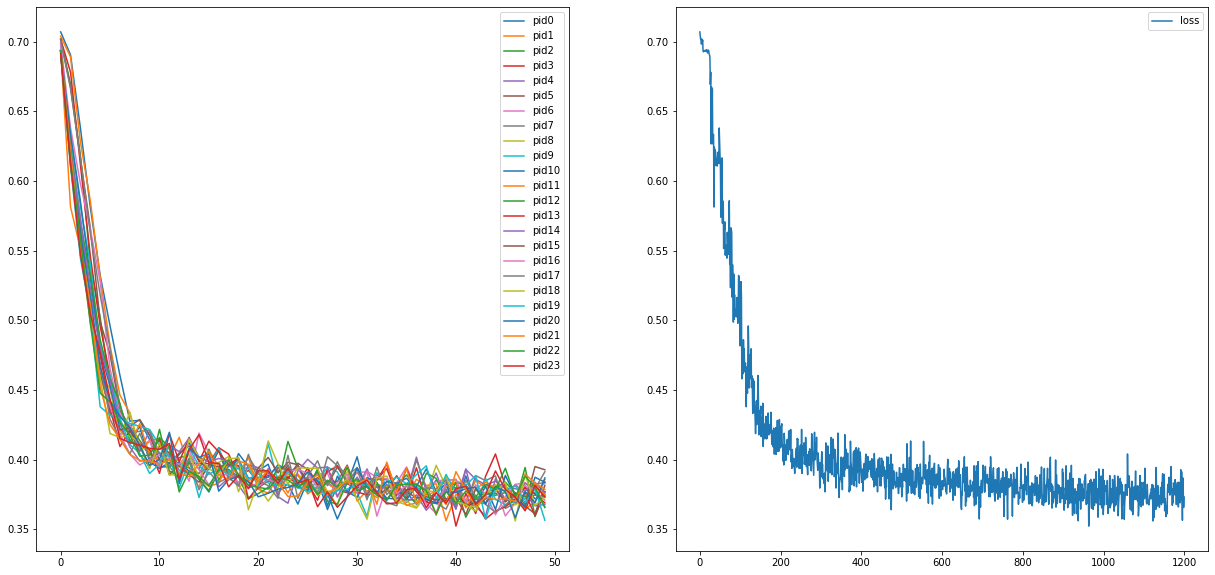

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch import multiprocessing as mp
from sklearn.datasets import make_classification
from matplotlib import  pyplot as plt
from sklearn.datasets import make_classification

def getData(size=800):
    time.sleep(0.3)
    X, y = make_classification(n_samples=10000, n_features=8, n_classes=2, random_state=42)
    np.random.seed(int((time.time() * 1E6) % (2**32 - 1)))
    idx = np.random.choice(np.arange(10000), size)
    return torch.from_numpy(X[idx]).float(), torch.from_numpy(y[idx])
model = torch.nn.Sequential(
        torch.nn.Linear(8, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 2),
        torch.nn.Softmax(dim=1),)
model.share_memory()
EPOCHS = 50
PROCESSES_NUM = 24
def train(args):
    (pid, model, loss_history) = args
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in range(EPOCHS):
        X, y = getData()
        y_p = model(X)
        optimizer.zero_grad()
        loss = loss_func(y_p, y)
        loss_history[pid, i] = loss.item()
        loss.backward()
        optimizer.step()

# loss_history = torch.zeros(PROCESSES_NUM, EPOCHS)
# with mp.Pool(PROCESSES_NUM) as pool:
#     pool.map(train, [(i, model, loss_history) for i in range(PROCESSES_NUM)])
loss_history = torch.zeros(PROCESSES_NUM, EPOCHS)
loss_history.share_memory_()
processes = []
for pid in range(PROCESSES_NUM):
    p = mp.Process(target=train, args=((pid, model, loss_history),))
    processes.append(p)
    p.start()
[p.join() for p in processes]
plt.figure(figsize=(21, 10))
# show the each process loss history
plt.subplot(1, 2, 1)
for i in range(PROCESSES_NUM):
    plt.plot(np.arange(EPOCHS), loss_history[i,:].numpy(), label=f'pid{i}')
plt.legend()
# show the all loss history
plt.subplot(1, 2, 2)
loss_history_1d = loss_history.T.reshape(-1)
plt.plot(np.arange(len(loss_history_1d)), loss_history_1d, label='loss')
plt.legend()
print(model.state_dict)